## Import Libraries and Frameworks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import pickle
import powerlaw

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

## Import Twitter Data

In [ ]:
notes = pd.read_csv('notes.tsv', sep="\t")
ratings = pd.read_csv('ratings.tsv', sep="\t")

## Import Processed Data

In [ ]:
with open('processed-3.pickle', 'rb') as handle:
    dictionary = pickle.load(handle)

In [ ]:
notesWithRatings = dictionary['notes 07/01/2021']

## Count Vectorizer

In [ ]:
cvec = CountVectorizer(min_df=.005, max_df=.9, ngram_range=(1,2), tokenizer=lambda doc: doc, lowercase=False)
cvec.fit(notesWithRatings['clean_summary'])

cvec_counts = cvec.transform(notesWithRatings['clean_summary'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
sparse matrix shape: (5231, 523)
nonzero count: 38811
sparsity: 1.42%


In [ ]:
# Instantiating the TfidfTransformer
transformer = TfidfTransformer()

# Fitting and transforming n-grams
transformed_weights = transformer.fit_transform(cvec_counts)

In [ ]:
# Getting a list of all n-grams
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()

# Putting weighted n-grams into a DataFrame and computing some summary statistics
model = pd.DataFrame(transformed_weights, columns=vocab)
model['Keyword'] = model.idxmax(axis=1)
model['Max'] = model.max(axis=1)
model['Sum'] = model.drop('Max', axis=1).sum(axis=1)

model = pd.concat([notesWithRatings.reset_index(), model], axis=1)

/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 25 Top Occurring Words

In [ ]:
# Getting a view of the top 25 occurring words
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(25)

,Term,Occurrences
481,tweet,796
66,claim,568
442,state,507
476,trump,498
136,election,494
144,evidence,481
321,people,471
491,vaccine,423
298,not,421
97,covid,409


In [ ]:
# Getting a view of the top 25 weights
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Weight': weights})
weights_df.sort_values(by='Weight', ascending=False).head(25)

/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Term,Weight
481,tweet,0.034761
66,claim,0.026567
298,not,0.021454
321,people,0.021131
144,evidence,0.020477
491,vaccine,0.020371
151,fact,0.019633
476,trump,0.018899
442,state,0.018641
39,biden,0.018315


2.0    2145
1.0    2065
0.0    1021
Name: helpful, dtype: int64


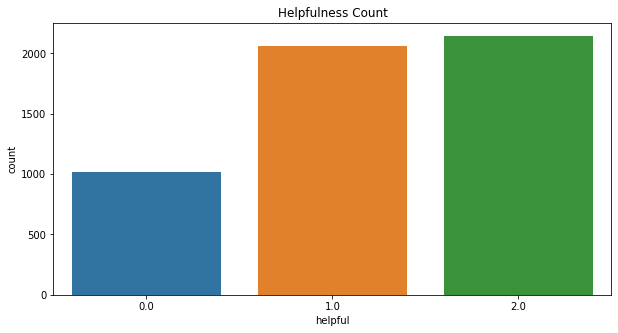

In [ ]:
# Plotting overall value counts of helpful categories
fig = plt.figure(figsize = (10,5))
sns.countplot(x='helpful', data = model).set_title('Helpfulness Count')

print(notesWithRatings['helpful'].value_counts())

helpful
0.0    0.319295
1.0    0.535593
2.0    0.811655
Name: has_links, dtype: float64

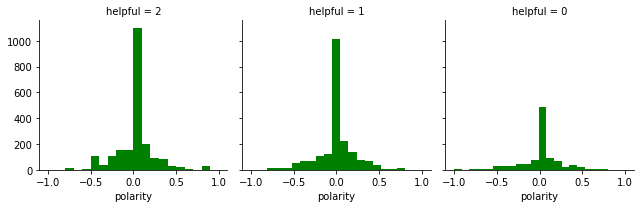

In [ ]:
# Visualizing value counts of helpful compared to their polarity and subjectivity scores.
g = sns.FacetGrid(model, col="helpful", col_order=[2, 1, 0])
g = g.map(plt.hist, "polarity", bins=20, color="g")

recommend = model.groupby(['helpful'])
recommend['has_links'].mean()

helpful
0.0    0.325657
1.0    0.318451
2.0    0.341472
Name: subjectivity, dtype: float64

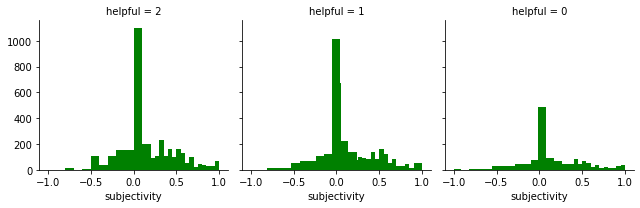

In [ ]:
g = g.map(plt.hist, "subjectivity", bins=20, color="g")
recommend['subjectivity'].mean()

Text(0.5, 1.0, 'Links vs. helpfulness score')

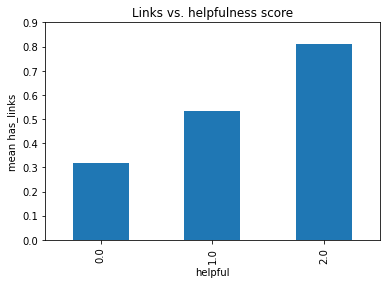

In [ ]:
recommend['has_links'].mean().plot(kind='bar', yticks=np.arange(0, 1, 0.1), ylabel="mean has_links").set_title('Links vs. helpfulness score')

In [ ]:
X = model.drop(model.columns[:54], axis=1)
X = X.drop(['Keyword', 'Max', 'Sum', 'clean_summary_as_str'], axis=1)
y_helpful = model['helpful'] == 2

In [ ]:
X

,accord,accord numerous,account,accurate,act,action,actual,actually,add,additionally,...,woman,word,work,worker,world,write,wrong,year,york,zero
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5227,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.300889,0.0,0.0
5228,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5229,0.0,0.0,0.376658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
X_train_help, X_test_help, y_train_help, y_test_help = train_test_split(X, y_helpful, test_size = 0.3, random_state=0)

In [ ]:
# Defining a function to fit and predict ML algorithms
def model_help(mod, model_name, x_train, y_train, x_test, y_test):
    mod.fit(x_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, x_train, y_train, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(mod, x_train, y_train, cv = 5)
    if y_train.mean() < 0.5:
        print("Guess Most Frequent Label ", 1-y_train.mean(), 1-y_test.mean()) 
    else:
         print("Guess Most Frequent Label ", y_train.mean(), y_test.mean())
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(predictions, y_train)
    print("Confusion Matrix:  \n", cm)
    print("                    Classification Report \n",classification_report(predictions, y_train))

In [ ]:
gnb = GaussianNB()
ran = RandomForestClassifier(n_estimators=50)
log = LogisticRegression()
svc = LinearSVC()

models = [gnb, ran, log, svc]
model_names = ["Gaussian", "Random Forest", "Logistic Regression", "Linear SVC"]

In [ ]:
for i in range(len(models)):
    model_help(models[i], model_names[i], X_train_help, y_train_help, X_test_help, y_test_help)

Gaussian
Guess Most Frequent Label  0.5916416279704999 0.5859872611464968
Accuracy: 0.629
Confusion Matrix:  
 [[1468  660]
 [ 698  835]]
                    Classification Report 
               precision    recall  f1-score   support

       False       0.68      0.69      0.68      2128
        True       0.56      0.54      0.55      1533

    accuracy                           0.63      3661
   macro avg       0.62      0.62      0.62      3661
weighted avg       0.63      0.63      0.63      3661

Random Forest
Guess Most Frequent Label  0.5916416279704999 0.5859872611464968
Accuracy: 0.647
Confusion Matrix:  
 [[1658  824]
 [ 508  671]]
                    Classification Report 
               precision    recall  f1-score   support

       False       0.77      0.67      0.71      2482
        True       0.45      0.57      0.50      1179

    accuracy                           0.64      3661
   macro avg       0.61      0.62      0.61      3661
weighted avg       0.66      0.6

## Plotting Word Feature Importance

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


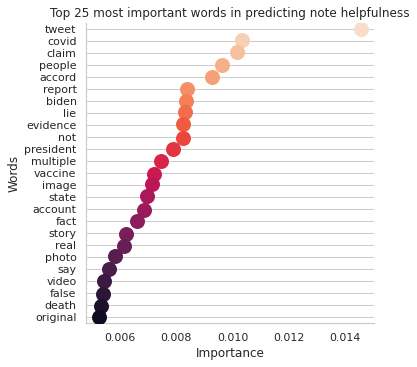

In [ ]:
# Creating a plot for feature importance
def importance_plotting(data,x,y,palette,title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data,y_vars=y,x_vars=x,size=5,aspect=1)
    ft.map(sns.stripplot,orient='h',palette=palette, edgecolor="black",size=15)
    for ax, title in zip(ft.axes.flat, titles):
        
    # Set a different title for each axes
        ax.set(title=title)
        
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    plt.show()

# Compile arrays of columns (words) and feature importances
# fi = {'Words':model.drop('helpful',axis=1).columns.tolist(),'Importance':log.coef_[0]}
fi = {'Words':X.columns.tolist(),'Importance':ran.feature_importances_}

# Bung these into a dataframe, rank highest to lowest then slice top 25
Importance = pd.DataFrame(fi,index=None).sort_values('Importance',ascending=False).head(25)

# Plot the graph
titles = ["Top 25 most important words in predicting note helpfulness"]
importance_plotting(Importance,'Importance','Words','rocket_r',titles)

## Helpfulness vs Time

In [ ]:
dates = [
    # LAST_DATE,
    '02/15/2021', 
    '03/01/2021', '03/15/2021', 
    '04/01/2021', '04/15/2021',
    '05/01/2021', '05/15/2021', 
    '06/01/2021', '06/15/2021',
    '07/01/2021', '07/15/2021',
    '08/01/2021', '08/15/2021', 
    '09/01/2021', '09/15/2021']
helpfulness = []
for date in dates:
    notes = dictionary['notes ' + date]
    avg = len(notes.loc[notes['helpful'] == 2]) / len(notes)
    helpfulness.append(avg)

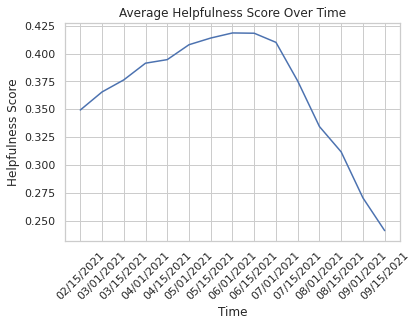

In [ ]:
df = pd.DataFrame({"Time": dates,
                   "Helpfulness Score": helpfulness})
sns.lineplot(x="Time", y="Helpfulness Score", data=df)
plt.xticks(rotation=45)
plt.title('Average Helpfulness Score Over Time')
plt.show()

## Power Law Distribution?

In [ ]:
notes_count = notes['participantId'].value_counts()
ratings_count = ratings['participantId'].value_counts()

In [ ]:
rating_results = powerlaw.Fit(ratings_count)
print(rating_results.power_law.alpha)
print(rating_results.power_law.xmin)
R, p = rating_results.distribution_compare('power_law', 'lognormal')
print('log likelihood: ', R)
print('significance of R', p)

Calculating best minimal value for power law fit
2.132900281310163
12.0
log likelihood:  -0.44718033342252816
significance of R 0.5734050449667039


In [ ]:
np.seterr(divide='ignore', invalid='ignore')
notes_results = powerlaw.Fit(notes_count)
print(notes_results.power_law.alpha)
print(notes_results.power_law.xmin)
R, p = notes_results.distribution_compare('power_law', 'lognormal')
print('log likelihood: ', R)
print('significance of R', p)

Calculating best minimal value for power law fit
2.4089227968126643
7.0
log likelihood:  -0.5909057698310973
significance of R 0.18623177570208616
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Text(0, 0.5, 'p(X), p(X>=x)')

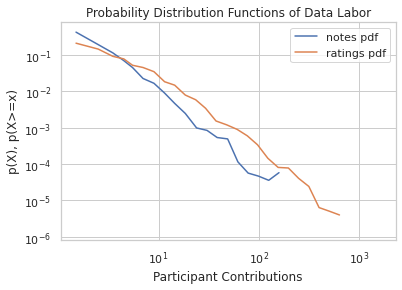

In [ ]:
plot = powerlaw.plot_pdf(notes_count)
powerlaw.plot_pdf(ratings_count, plot)
plot.set_title("Probability Distribution Functions of Data Labor")
plot.legend(['notes pdf', 'ratings pdf'])
plot.set_xlabel("Participant Contributions")
plot.set_ylabel("p(X), p(X>=x)")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c0e62a2c-7f45-414e-8164-5bf51e09d482' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>